In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
from scipy.stats import norm
from matplotlib_venn import venn2, venn2_unweighted
from matplotlib.patches import FancyBboxPatch
from statsmodels.stats.proportion import proportions_ztest
from itertools import combinations   
import networkx as nx
import hypernetx as hnx
import hypernetx.algorithms.hypergraph_modularity as hmod


# personal modules
import databases as db
import kuzmin_data_2018 as data_2018
import kuzmin_data_2020 as data_2020
import enrichment as enrich


In [2]:
dataset = "Kuzmin2020" # Kuzmin2020 or Kuzmin2018

In [3]:
if dataset == "Kuzmin2018":
    kuzmin_2018_data_dir = "/Users/bjarnold/Princeton_DataX/Epistasis/higher_order_reanalysis/yeast_screens/KuzminEtAl2018/data_files"
    kuzmin_2018_s1, kuzmin_2018_s1_digenic, kuzmin_2018_s1_trigenic = data_2018.load_kuzmin_2018_s1(kuzmin_2018_data_dir)

    costanzo_et_al_data_dir = "/Users/bjarnold/Princeton_DataX/Epistasis/higher_order_reanalysis/yeast_screens/CostanzoEtAl2016/data_files/Data File S1. Raw genetic interaction datasets: Pair-wise interaction format"
    costanzo_data = data_2018.load_costanzo_data(costanzo_et_al_data_dir)
    #kuzmin_2020_s3, kuzmin_2020_s3_digenic = data.load_kuzmin_2020_s3(kuzmin_2020_data_dir)
    #kuzmin_2020_s5, kuzmin_2020_s5_singMut, kuzmin_2020_s5_dblMut = data.load_kuzmin_2020_s5(kuzmin_2020_data_dir)
    #kuzmin_2020_s2 = data.load_kuzmin_2020_s2(kuzmin_2020_data_dir)


    #print(kuzmin_2020_s1.combined_mutant_type.value_counts())
    #print(kuzmin_2020_s2.combined_mutant_type.value_counts())


    # f_i and f_j taken from costanzo, f_k taken from array allele in kuzmin 2018

    f_k_SMF = dict(zip(kuzmin_2018_s1_trigenic.array_allele_name, kuzmin_2018_s1_trigenic.array_single_mutant_fitness))

    s1 = pd.concat([costanzo_data.query_allele_name, costanzo_data.array_allele_name], axis=0)
    s2 = pd.concat([costanzo_data.query_smf, costanzo_data.array_smf], axis=0)
    df = pd.concat([s1, s2], axis=1).rename(columns={0:"allele", 1:"value"})
    df = df.drop_duplicates(subset=["allele"], keep='first').reset_index(drop=True)
    f_i_j_SMF = dict(zip(df.allele, df.value))

    # f_ij from query fitness in trigenic table
    # f_ik and f_jk from fitness digenic table
    f_ij_DMF = dict(zip(kuzmin_2018_s1_trigenic.query_allele_name, kuzmin_2018_s1_trigenic.query_single_double_mutant_fitness))
    f_ik_jk_DMF = dict(zip(kuzmin_2018_s1_digenic.alleles, kuzmin_2018_s1_digenic.query_single_double_mutant_fitness))

    #e_ik and e_jk come from the digenic portion of the Kuzmin 2018 S1 table
    e_ik_jk_DMF = dict(zip(kuzmin_2018_s1_digenic.alleles, kuzmin_2018_s1_digenic.raw_interaction_score_epsilon))

    f_i, f_j, f_k, f_ij, f_ik, f_jk, e_ik_kuz, e_jk_kuz = data_2018.consolidate_fitnesses_across_2018_tables(kuzmin_2018_s1_trigenic,
                                                                                                        f_k_SMF,
                                                                                                        f_i_j_SMF,
                                                                                                        f_ij_DMF,
                                                                                                        f_ik_jk_DMF,
                                                                                                        e_ik_jk_DMF)
                                                            
    df = kuzmin_2018_s1_trigenic

if dataset == "Kuzmin2020":
    kuzmin_2020_data_dir = "/Users/bjarnold/Princeton_DataX/Epistasis/higher_order_reanalysis/yeast_screens/KuzminEtAl2020"
    kuzmin_2020_s1, kuzmin_2020_s1_digenic, kuzmin_2020_s1_trigenic = data_2020.load_kuzmin_2020_s1(kuzmin_2020_data_dir)
    kuzmin_2020_s3, kuzmin_2020_s3_digenic = data_2020.load_kuzmin_2020_s3(kuzmin_2020_data_dir)
    kuzmin_2020_s5, kuzmin_2020_s5_singMut, kuzmin_2020_s5_dblMut = data_2020.load_kuzmin_2020_s5(kuzmin_2020_data_dir)
    kuzmin_2020_s2 = data_2020.load_kuzmin_2020_s2(kuzmin_2020_data_dir)
    kuzmin_2020_s10 = data_2020.load_kuzmin_2020_s10(kuzmin_2020_data_dir)


    print(kuzmin_2020_s1.combined_mutant_type.value_counts())
    print(kuzmin_2020_s2.combined_mutant_type.value_counts())

    kuzmin_2020_s1_dblMutFit = dict(zip(kuzmin_2020_s1_digenic.alleles, kuzmin_2020_s1_digenic.double_triple_mutant_fitness))
    kuzmin_2020_s1_epsilon = dict(zip(kuzmin_2020_s1_digenic.alleles, kuzmin_2020_s1_digenic.raw_interaction_score_epsilon))
    kuzmin_2020_s1_singMutFit = dict(zip(kuzmin_2020_s1.array_allele_name, kuzmin_2020_s1.array_single_mutant_fitness))

    kuzmin_2020_s3_singMutFit = dict(zip(kuzmin_2020_s3.array_allele_name, kuzmin_2020_s3.array_single_mutant_fitness))

    kuzmin_2020_s5_dblMut = kuzmin_2020_s5[kuzmin_2020_s5.mutant_type == "Double mutant"]
    kuzmin_2020_s5_singMut = kuzmin_2020_s5[kuzmin_2020_s5.mutant_type == "Single mutant"]

    kuzmin_2020_s5_dblMutFit = dict(zip(kuzmin_2020_s5_dblMut.alleles, kuzmin_2020_s5_dblMut.fitness))
    kuzmin_2020_s5_singMutFit = dict(zip(kuzmin_2020_s5_singMut.alleles, kuzmin_2020_s5_singMut.fitness))


    f_i, f_j, f_k, f_ij, f_ik, f_jk, e_ik_kuz, e_jk_kuz = data_2020.consolidate_fitnesses_across_tables(kuzmin_2020_s1_trigenic,
                                                                                            kuzmin_2020_s1_dblMutFit,
                                                                                            kuzmin_2020_s1_singMutFit,
                                                                                            kuzmin_2020_s1_epsilon,
                                                                                            kuzmin_2020_s3_singMutFit,
                                                                                            kuzmin_2020_s5_singMutFit,
                                                                                            kuzmin_2020_s5_dblMutFit)

    # incorporate fitnesses into the data frame so that for each triplet of genes, we have all relevant fitness values in the same row to calculate interactions
    # since we will be mostly using kuzmin_2020_s1_trigenic going forwards, lets rename it to df

    df = kuzmin_2020_s1_trigenic


digenic     537911
trigenic    256861
Name: combined_mutant_type, dtype: int64
digenic     7197
trigenic    4557
Name: combined_mutant_type, dtype: int64


In [4]:
names = ['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik', 'f_jk', 'e_ik_kuz', 'e_jk_kuz']
vars = [f_i, f_j, f_k, f_ij, f_ik, f_jk, e_ik_kuz, e_jk_kuz]
for i in range(len(names)):
    n = names[i]
    v = vars[i]
    print(n, "\t", np.sum(np.isnan(np.array([i for i in v.values()]))))

f_i 	 30434
f_j 	 2098
f_k 	 0
f_ij 	 41244
f_ik 	 11
f_jk 	 88
e_ik_kuz 	 11
e_jk_kuz 	 88


#############################################################

AFTER THIS POINT ALL CODE IS REDUNDANT WITH THE 2020 ANALYSIS

#############################################################


In [5]:
df['f_ij'] = df['alleles'].map(f_ij)
df['f_ik'] = df['alleles'].map(f_ik)
df['f_jk'] = df['alleles'].map(f_jk)

df['f_i'] = df['alleles'].map(f_i)
df['f_j'] = df['alleles'].map(f_j)
df['f_k'] = df['alleles'].map(f_k)

df['e_ik_kuz'] = df['alleles'].map(e_ik_kuz)
df['e_jk_kuz'] = df['alleles'].map(e_jk_kuz)

In [6]:
print(np.sum(~np.isnan(df.f_ij)))
print(np.sum(~np.isnan(df.f_ik)))
print(np.sum(~np.isnan(df.f_jk)))
print(np.sum(~np.isnan(df.f_i)))
print(np.sum(~np.isnan(df.f_j)))
print(np.sum(~np.isnan(df.f_k)))
print()
print(np.sum(~np.isnan(df.e_ik_kuz)))
print(np.sum(~np.isnan(df.e_jk_kuz)))

#print(len(kuzmin_2020_s1_trigenic.f_ik))
print(len(df.dropna(subset=['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik', 'f_jk', 'e_ik_kuz', 'e_jk_kuz'])))
print(len(df.dropna(subset=['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik', 'f_jk'])))
print(len(df))
print(len(df.dropna(subset=['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik', 'f_jk']))/len(df))

215617
256850
256773
226427
254763
256861

256850
256773
189340
189340
256861
0.7371301988234882


fraction of tau values that remain after filtering out deviants


/Users/bjarnold/miniconda/envs/epistasis_reanalysis/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0.9891940424632936


,tau_kuzmin_orig,adjusted_interaction_score_epsilon_or_tau
tau_kuzmin_orig,1.000000,0.997447
adjusted_interaction_score_epsilon_or_tau,0.997447,1.000000


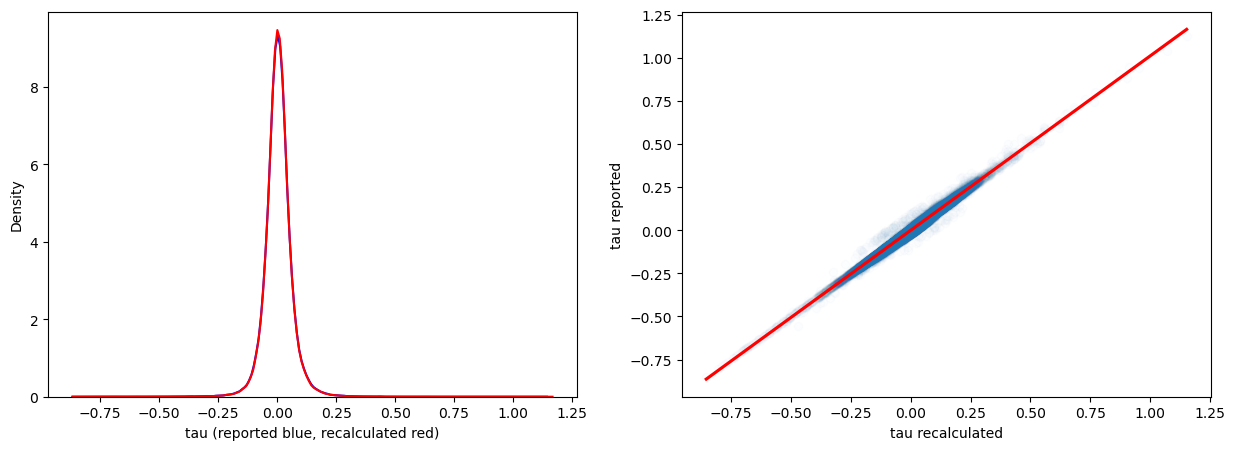

In [7]:
# To ensure we appropriately understand the data, we recalculate tau (trigenic interaction) using the formula in the supplement of Kuzmin 2018.
# These values *should* correspond to those reported in the 'adjusted_interaction_score_epsilon_or_tau' column. Around ~1% of recalculated tau values
# strongly deviate from those reported, and we filter these out.

df = df.dropna(subset=['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik', 'f_jk', 'e_ik_kuz', 'e_jk_kuz'])
threshold = 0.1

df['tau_kuzmin_orig'] = df.double_triple_mutant_fitness - df.f_ij*df.f_k - df.e_ik_kuz*df.f_j - df.e_jk_kuz*df.f_i

# filter out results that aren't reproducible according to the original equation
print("fraction of tau values that remain after filtering out deviants")
print(len(df[abs(df.tau_kuzmin_orig - df.adjusted_interaction_score_epsilon_or_tau) <= threshold])/len(df))

df = df[abs(df.tau_kuzmin_orig - df.adjusted_interaction_score_epsilon_or_tau) <= threshold]

fig, axs = plt.subplots(ncols=2, figsize=(15,5))

p = sns.kdeplot(df['adjusted_interaction_score_epsilon_or_tau'], ax=axs[0], color="blue")
p = sns.kdeplot(df['tau_kuzmin_orig'], ax=axs[0], color="red")
p.set(xlabel='tau (reported blue, recalculated red)')

p = sns.regplot(x=df['tau_kuzmin_orig'],
            y=df['adjusted_interaction_score_epsilon_or_tau'],
            scatter_kws={'alpha':0.01},
            line_kws={'color': 'red'},
            ax=axs[1])
p.set(xlabel='tau recalculated', ylabel='tau reported')

df[['tau_kuzmin_orig', 'adjusted_interaction_score_epsilon_or_tau']].corr(method="pearson")


In [8]:
df.loc[:, 'tau_cumulant'] = df.double_triple_mutant_fitness + 2*df.f_i*df.f_j*df.f_k - df.f_i*df.f_jk - df.f_j*df.f_ik - df.f_k*df.f_ij

df.loc[:,'e_ik_mult'] = df.f_ik/(df.f_i*df.f_k)
df.loc[:,'e_jk_mult'] = df.f_jk/(df.f_j*df.f_k)
#df.loc[:,'tau_multiplicative'] = df.double_triple_mutant_fitness/(df.f_ij*df.f_k*df.e_ik_mult*df.e_jk_mult) 
df.loc[:,'tau_multiplicative'] = (df.double_triple_mutant_fitness*df.f_i*df.f_j*df.f_k)/(df.f_ij*df.f_ik*df.f_jk) 



# tau_cumulant (forumula from cumulant formula) calculated above should be equivalent to tau_kuzmin_orig (formula from Kuzmin et al 2018).
# One can substitute (f_jk - f_j*f_k) for e_jk and (f_ik - f_i*f_k) for e_ik into the Kuzmin et al 2018 formula to get the cumulant formula
# However, the results using these two equivalent formula aren't the same because  f_jk != (f_j*f_k + e_jk) and  f_ik != (f_i*f_k + e_ik)

# subsituting in (f_j*f_k + e_jk) for f_jk and (f_i*f_k + e_ik) for f_ik
# This gives trigenic interaction scores that are similar to reported values, see sanityChecks notebook
# newly recalculated double mutant fitnesses, and corresponding interactions, are suffixed with 2

df.loc[:, 'f_ik_2'] = df.f_i*df.f_k + df.e_ik_kuz
df.loc[:, 'f_jk_2'] = df.f_j*df.f_k + df.e_jk_kuz

df.loc[df['f_ik_2'] < 0, ['f_ik_2']] = np.nan
df.loc[df['f_jk_2'] < 0, ['f_jk_2']] = np.nan

df.loc[:,'e_ik_mult2'] = df.f_ik_2/(df.f_i*df.f_k)
df.loc[:,'e_jk_mult2'] = df.f_jk_2/(df.f_j*df.f_k)

df.loc[:, 'tau_cumulant2'] = df.double_triple_mutant_fitness + 2*df.f_i*df.f_j*df.f_k - df.f_i*df.f_jk_2 - df.f_j*df.f_ik_2 - df.f_k*df.f_ij

# calculate multiplicative results using the custom dbl mutant fitnesses that gave results consistent with those reported (above)
# compare these with tau_cumulant2
#df.loc[:,'tau_multiplicative2'] = df.double_triple_mutant_fitness/(df.f_ij*df.f_k*df.e_ik_mult2*df.e_jk_mult2) 
df.loc[:,'tau_multiplicative2'] = (df.double_triple_mutant_fitness*df.f_i*df.f_j*df.f_k)/(df.f_ij*df.f_ik_2*df.f_jk_2) 

,tau_cumulant2,adjusted_interaction_score_epsilon_or_tau
tau_cumulant2,1.000000,0.997449
adjusted_interaction_score_epsilon_or_tau,0.997449,1.000000


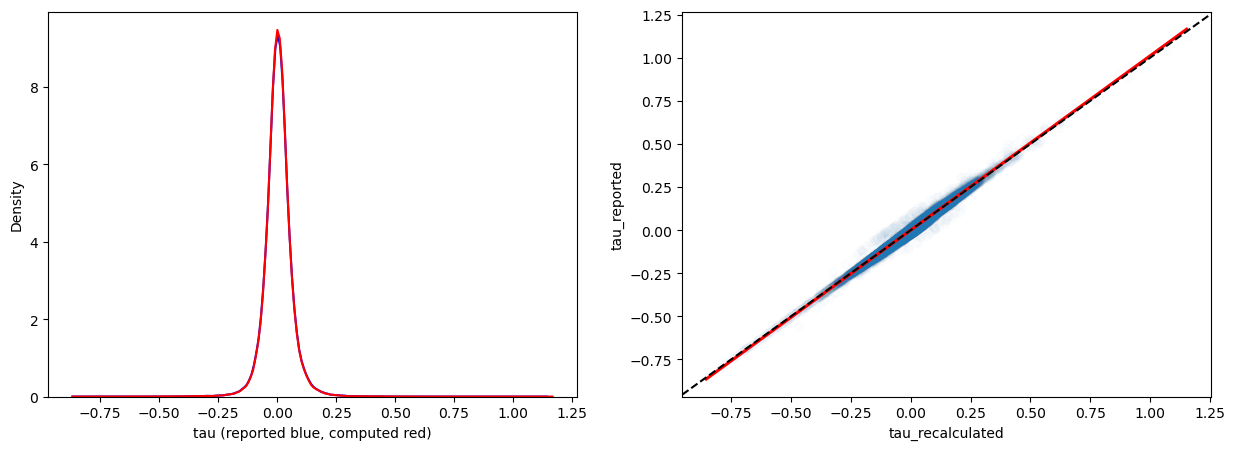

In [9]:
tau = "tau_cumulant2"

fig, axs = plt.subplots(ncols=2, figsize=(15,5))

p = sns.kdeplot(df['adjusted_interaction_score_epsilon_or_tau'], ax=axs[0], color="blue")
p = sns.kdeplot(df[tau], ax=axs[0], color="red")
p.set(xlabel='tau (reported blue, computed red)')

p = sns.regplot(x=df[tau],
            y=df['adjusted_interaction_score_epsilon_or_tau'],
            scatter_kws={'alpha':0.01},
            line_kws={'color': 'red'},
            ax=axs[1])
p.set(xlabel='tau_recalculated', ylabel='tau_reported')
axs[1].axline([-0.75, -0.75], [1, 1], linestyle="--", color="black")

df[[tau, 'adjusted_interaction_score_epsilon_or_tau']].corr(method="pearson")

In [10]:
# This logical switch is used to change all downstream analyses

use_reported_double_mutant_fitnesses = False
compare_to_reported_values = True # if False, compare instead to values recalculated with cumulant formula

if use_reported_double_mutant_fitnesses:
    multiplicative = "tau_multiplicative"
    cumulant = "tau_cumulant"
else:
    multiplicative = "tau_multiplicative2"
    cumulant = "tau_cumulant2"

if compare_to_reported_values:
    compare = "adjusted_interaction_score_epsilon_or_tau"
else:
    compare = cumulant

In [11]:
# To see how outliers vary across scales, we can calculate a significance threshold for the multiplicative scale by 
# finding the quantile that corresponds +/- 0.08, the trigenic score Kuzmin et al use to find positive/negative outliers.

tau_reported_sig_quant, tau_mult_sig_val, tau_iss_sig_val = {},{},{}

# get quantiles
tau_reported_sig_quant['neg'] = np.mean( np.array(df.adjusted_interaction_score_epsilon_or_tau) < -0.08)
tau_reported_sig_quant['pos'] = 1 - np.mean( np.array(df.adjusted_interaction_score_epsilon_or_tau) > 0.08)

# calculate significance thresholds on new scales using quantile
tau_mult_sig_val['neg'] = np.nanquantile(df[multiplicative], tau_reported_sig_quant['neg'])
tau_mult_sig_val['pos'] = np.nanquantile(df[multiplicative], tau_reported_sig_quant['pos'])

tau_iss_sig_val['neg'] = np.nanquantile(df[cumulant], tau_reported_sig_quant['neg'])
tau_iss_sig_val['pos'] = np.nanquantile(df[cumulant], tau_reported_sig_quant['pos'])

print("quantiles of the significant values they used",  tau_reported_sig_quant['neg'], tau_reported_sig_quant['pos'] )
print("confirming (should be -0.08):", np.quantile(df.adjusted_interaction_score_epsilon_or_tau, tau_reported_sig_quant['neg']))
print("confirming (should be 0.08):", np.quantile(df.adjusted_interaction_score_epsilon_or_tau, tau_reported_sig_quant['pos']))
print()
print( "corresponding cutoffs for multiplicative model: ", tau_mult_sig_val['neg'], tau_mult_sig_val['pos'])
print( "corresponding cutoffs for cumulant model: ", tau_iss_sig_val['neg'], tau_iss_sig_val['pos'])


quantiles of the significant values they used 0.0505675568891689 0.9305530342669813
confirming (should be -0.08): -0.07998675851335334
confirming (should be 0.08): 0.07998704170448598

corresponding cutoffs for multiplicative model:  0.9051323011432824 1.1071547776828772
corresponding cutoffs for cumulant model:  -0.07906997897906276 0.07887639643511796


/Users/bjarnold/miniconda/envs/epistasis_reanalysis/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


                                           tau_multiplicative2  \
tau_multiplicative2                                   1.000000   
adjusted_interaction_score_epsilon_or_tau             0.983062   

                                           adjusted_interaction_score_epsilon_or_tau  
tau_multiplicative2                                                         0.983062  
adjusted_interaction_score_epsilon_or_tau                                   1.000000  
                                           tau_multiplicative2  \
tau_multiplicative2                                   1.000000   
adjusted_interaction_score_epsilon_or_tau             0.915095   

                                           adjusted_interaction_score_epsilon_or_tau  
tau_multiplicative2                                                         0.915095  
adjusted_interaction_score_epsilon_or_tau                                   1.000000  
                                           tau_multiplicative2  \
tau_multiplica

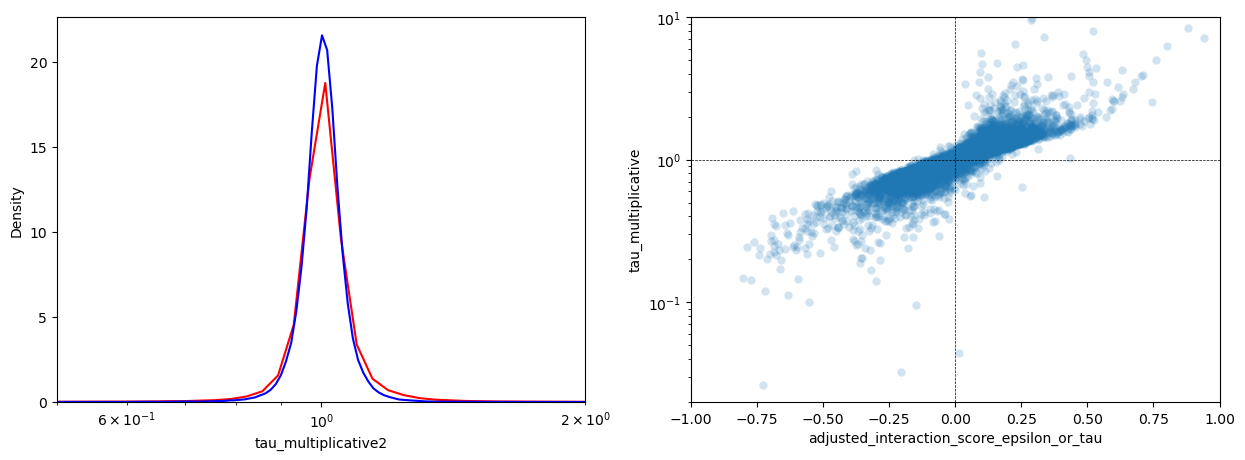

In [12]:
# How do multiplicative values compare to 

fig, axs = plt.subplots(ncols=2, figsize=(15,5))

bw_param =10
p = sns.kdeplot(df[multiplicative], ax = axs[0], color="red", log_scale=True)
#p = sns.kdeplot(df[multiplicative], ax = axs[0], color="red")
# add one so distributions are more comparable
p = sns.kdeplot(df[compare]+1, ax = axs[0], color="blue")
axs[0].set_xlim(0.5,2)

p = sns.scatterplot(x=df[compare],
            y=df[multiplicative],
            alpha=0.2,
            linewidth=0,
            ax=axs[1])
p.set(xlabel=compare, ylabel='tau_multiplicative')
axs[1].set_xlim(-1,1)
axs[1].set_yscale('log')
axs[1].set_ylim(0.02,10)
axs[1].axhline(1, color="black", linestyle="--", linewidth=0.5)
axs[1].axvline(0, color="black", linestyle="--", linewidth=0.5)
#axs[1].axhline(tau_mult_sig_val['neg'], color="red", linestyle="--", linewidth=0.5)
#axs[1].axhline(tau_mult_sig_val['pos'], color="red", linestyle="--", linewidth=0.5)
#axs[1].axvline(-0.08, color="red", linestyle="--", linewidth=0.5)
#axs[1].axvline(0.08, color="red", linestyle="--", linewidth=0.5)

print(df[[multiplicative, compare]].corr(method="spearman"))
print(df[[multiplicative, compare]].corr(method="kendall"))
print(df[[multiplicative, compare]].corr(method="pearson"))


In [13]:
def count_frac(df):
    return len(df)
    
results = defaultdict(list)
p = 0.05

overlap, only_reported, only_mult, all_reported, all_mult = enrich.outlier_enrichment( df[df.pval < p], "negative", count_frac, multiplicative, tau_mult_sig_val)
denom = overlap + only_reported + only_mult

results['type'].extend(['overlap', 'only reported', 'only multiplicative'])
results['number'].extend([overlap, only_reported, only_mult])
results['fraction'].extend([overlap/denom, only_reported/denom, only_mult/denom])

#overlap, only_reported, only_mult, all_reported, all_mult = enrich.outlier_enrichment( df[df.pval < p], "positive", count_frac, multiplicative, tau_mult_sig_val)
#denom = overlap + only_reported + only_mult

#results['type'].extend(['overlap_positive', 'only reported positive', 'only mult positive'])
#results['number'].extend([overlap, only_reported, only_mult])
#results['fraction'].extend([overlap/denom, only_reported/denom, only_mult/denom])

pd.DataFrame.from_dict(results)

,type,number,fraction
0,overlap,1527,0.729226
1,only reported,91,0.043457
2,only multiplicative,476,0.227316


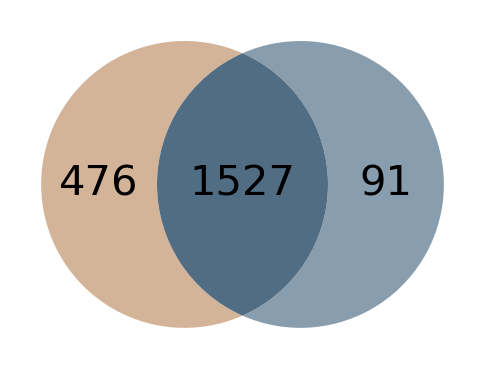

In [14]:
overlap_color = "#506D84"
only_mult_color = "#D4B499"
only_reported_color = "#889EAF"

only_mult_venn, only_reported_venn, overlap_venn = None, None, None
# copy values since similar names get used elsewhere in notebook
if not only_mult_venn and not only_reported_venn and not overlap_venn:
    only_mult_venn = only_mult
    only_reported_venn = only_reported
    overlap_venn = overlap

#plt.subplot(figsize=(15,15))
plt.figure(figsize=(6,6))
v = venn2_unweighted(subsets = (only_mult, only_reported, overlap), set_labels = ('', '', ''), set_colors=(only_mult_color, 
                                                                                            only_reported_color,
                                                                                            overlap_color), alpha = 1)
v.get_patch_by_id('11').set_color(overlap_color)
v.get_patch_by_id('11').set_edgecolor('none')
v.get_patch_by_id('11').set_alpha(1)

#v = venn2(subsets = (only_mult, only_reported, overlap), set_labels = ('multiplicative', 'reported'), set_colors=('#b2df8a', '#1f78b4', '#a6cee3'), alpha = 0.7)
#out = venn3([set1, set2, set3], ('Set1', 'Set2', 'Set3'))
for text in v.set_labels:
    text.set_fontsize(14)
for text in v.subset_labels:
    text.set_fontsize(30)

print(v)
plt.show()

In [15]:
# See if outliers are enriched for other biological signals. Here we load in pairwise physical interactions from one of two databases.
# 'physical_pairwise_interactions_set' contains a set of sorted 2-tuples of genes particupating in pairwise protein interactions

#physical_pairwise_interactions_set = db.get_physical_interactions_yeastGenomeDotOrg()

# BIOGRID contains physical interactions measured from a variety of assays including co-localization
# see here for explanation of experimental evidence codes: https://wiki.thebiogrid.org/doku.php/experimental_systems
db_interactions = db.get_physical_interactions_BIOGRID()
experimental_systems = ['Affinity Capture-MS', 'Affinity Capture-Western', 'Two-hybrid', 'Reconstituted Complex', 'PCA', 'Co-purification', 'Co-crystal Structure']
#experimental_systems = ['Affinity Capture-RNA']
#experimental_systems = ['Biochemical Activity']
#experimental_systems = ['Co-localization']
print(db_interactions.experimental_system.value_counts())

db_interactions = db_interactions[db_interactions.experimental_system.isin(experimental_systems)]
#db_interactions = db_interactions[db_interactions.experimental_system_type == "physical"]
#db_interactions

/Users/bjarnold/miniconda/envs/epistasis_reanalysis/lib/python3.7/site-packages/ipykernel_launcher.py:8: DtypeWarning: Columns (1,2,18) have mixed types.Specify dtype option on import or set low_memory=False.
  


Negative Genetic                 419139
Affinity Capture-MS               95645
Positive Genetic                  83564
Synthetic Growth Defect           28938
Affinity Capture-RNA              27787
Affinity Capture-Western          21182
Two-hybrid                        19089
Synthetic Lethality               17342
Reconstituted Complex             10560
Synthetic Rescue                   9534
Phenotypic Enhancement             9265
Phenotypic Suppression             8930
Biochemical Activity               7400
PCA                                7311
Dosage Rescue                      6919
Co-purification                    5314
Dosage Lethality                   2277
Dosage Growth Defect               2244
Co-crystal Structure               1246
Co-fractionation                   1245
Proximity Label-MS                  939
Protein-peptide                     933
Co-localization                     898
Protein-RNA                         674
Synthetic Haploinsufficiency        307


In [16]:
physical_pairwise_interactions_set = db.find_unique_interactions(db_interactions, 'official_symbol_interactor_a', 'official_symbol_interactor_b')
num_physical_interactions, oneplus_physical_interactions, twoplus_physical_interactions, three_physical_interactions = db.count_interactions_in_set(df, physical_pairwise_interactions_set)
#df['num_physical_interactions'] = df['alleles'].map(num_physical_interactions)
#df['twoplus_physical_interactions'] = df['alleles'].map(twoplus_physical_interactions)
df['three_physical_interactions'] = df['alleles'].map(three_physical_interactions)

#print()
#print(df['num_physical_interactions'].value_counts())

physical_pairwise_interactions_dict = db.collect_interactions_in_dict(db_interactions, 'official_symbol_interactor_a', 'official_symbol_interactor_b')
three_shared_physical_interactions = db.count_shared_interactions_in_dict(df, physical_pairwise_interactions_dict, 1)
df['three_shared_physical_interactions'] = df['alleles'].map(three_shared_physical_interactions)

In [17]:
overlap, only_reported, only_mult, all_reported, all_mult = enrich.outlier_enrichment(df[df.pval < p], "negative", enrich.fraction_three_shared, multiplicative, tau_mult_sig_val)
# since all_mult has more observations than all_reported, treat all_mult as the "population" and all_reported as the "sample" for the hypergeometric test
# and use the hypergeom cdf to do a lower-tailed test
test = hypergeom.cdf(*enrich.get_hypergeom_params(only_reported, only_mult))

print(test)

0.0018470935845176395


In [18]:
# arg that goes into get_coexpression_gene_pairs is the z-score associated with how significant the correlation b/t expression is
coexpression_gene_pairs_set, divexpression_gene_pairs_set = db.get_expression_gene_pairs(3)

num_coex_interactions, oneplus_coex_interactions, twoplus_coex_interactions, three_coex_interactions = db.count_interactions_in_set(df, coexpression_gene_pairs_set)
num_divex_interactions, oneplus_divex_interactions, twoplus_divex_interactions, three_divex_interactions = db.count_interactions_in_set(df, divexpression_gene_pairs_set)

df['num_coex_interactions'] = df['alleles'].map(num_coex_interactions)
df['oneplus_coex_interactions'] = df['alleles'].map(oneplus_coex_interactions)
df['twoplus_coex_interactions'] = df['alleles'].map(twoplus_coex_interactions)
df['three_coex_interactions'] = df['alleles'].map(three_coex_interactions)

df['num_divex_interactions'] = df['alleles'].map(num_divex_interactions)
df['oneplus_divex_interactions'] = df['alleles'].map(oneplus_divex_interactions)
df['twoplus_divex_interactions'] = df['alleles'].map(twoplus_divex_interactions)
df['three_divex_interactions'] = df['alleles'].map(three_divex_interactions)

print(df['num_coex_interactions'].value_counts())


0    134619
1     51800
2       662
3       213
Name: num_coex_interactions, dtype: int64


In [19]:
print("COEXPRESSION ENRICHMENT P-VALUES")
print(enrich.perform_hypergeom_test(df[df.pval < p], "negative", enrich.fraction_coex_twoplus, multiplicative, tau_mult_sig_val))

print("GO ENRICHMENT P-VALUES")
print(enrich.perform_hypergeom_test(df[df.pval < p], "negative", enrich.alleles_2_go_enrichment, multiplicative, tau_mult_sig_val))

print("SHARED PPI ENRICHMENT P-VALUES")
print(enrich.perform_hypergeom_test(df[df.pval < p], "negative", enrich.fraction_three_shared, multiplicative, tau_mult_sig_val))

COEXPRESSION ENRICHMENT P-VALUES
            type      pval
0        overlap  0.016389
1  only_reported  0.274767
2      only_mult  0.017843
3   all_reported  0.018366
4       all_mult  0.001305
GO ENRICHMENT P-VALUES
            type          pval
0        overlap  1.114508e-05
1  only_reported  4.206507e-01
2      only_mult  2.094051e-05
3   all_reported  1.601012e-05
4       all_mult  5.058710e-10
SHARED PPI ENRICHMENT P-VALUES
            type          pval
0        overlap  1.096267e-03
1  only_reported  8.933415e-01
2      only_mult  1.418961e-04
3   all_reported  4.046685e-03
4       all_mult  9.495357e-07


In [20]:
#overlap, only_reported, only_mult, all_reported, all_mult = enrich.outlier_enrichment(df[df.pval < p], "negative", enrich.alleles_2_go_enrichment, multiplicative, tau_mult_sig_val)
overlap, only_reported, only_mult, all_reported, all_mult = enrich.outlier_enrichment( df[df.pval < p], "negative", count_frac, multiplicative, tau_mult_sig_val)

print(overlap)
print(only_reported)
print(only_mult)
print((all_reported), overlap+only_reported)
print((all_mult), overlap+only_mult)
print(len(df[df[multiplicative] <= tau_mult_sig_val['neg']]))
print(len(df[df.adjusted_interaction_score_epsilon_or_tau <= -0.08]))

1527
91
476
1618 1618
2003 2003
9471
9471


In [21]:
# Directly compare multiplicative and reported using hypergeometric test

def get_sample_population(all_reported, all_mult):
    if all_mult['tot'] >= all_reported['tot']:
        # perform lower tail test to see if all_reported significantly less enriched
        return all_reported, all_mult, "lower" 
    else:
        # perform upper tail test to see if all_mult more enriched
        return all_mult, all_reported, "upper"

print("DIRECTLY COMPARE MULT AND REPORTED")
print("GO ENRICHMENT")
overlap, only_reported, only_mult, all_reported, all_mult = enrich.outlier_enrichment(df[df.pval < p], "negative", enrich.alleles_2_go_enrichment, multiplicative, tau_mult_sig_val)
# since all_mult has more observations than all_reported, treat all_mult as the "population" and all_reported as the "sample" for the hypergeometric test
# and use the hypergeom cdf to do a lower-tailed test
sample, population, test_tail = get_sample_population(all_reported, all_mult)
print(all_reported)
print(all_mult)
if test_tail == "lower":
    test = hypergeom.cdf(*enrich.get_hypergeom_params(sample, population))
elif test_tail == "upper":
    test = 1-hypergeom.cdf(*enrich.get_hypergeom_params(sample, population))
print(test)

print("shared PPI")
overlap, only_reported, only_mult, all_reported, all_mult = enrich.outlier_enrichment(df[df.pval < p], "negative", enrich.fraction_three_shared, multiplicative, tau_mult_sig_val)
# since all_mult has more observations than all_reported, treat all_mult as the "population" and all_reported as the "sample" for the hypergeometric test
# and use the hypergeom cdf to do a lower-tailed test
sample, population, test_tail = get_sample_population(all_reported, all_mult)
print(all_reported)
print(all_mult)
if test_tail == "lower":
    test = hypergeom.cdf(*enrich.get_hypergeom_params(sample, population))
elif test_tail == "upper":
    test = 1-hypergeom.cdf(*enrich.get_hypergeom_params(sample, population))
print(test)

print("COEXPRESSION")
overlap, only_reported, only_mult, all_reported, all_mult = enrich.outlier_enrichment(df[df.pval < p], "negative", enrich.fraction_coex_twoplus, multiplicative, tau_mult_sig_val)
# since all_mult has more observations than all_reported, treat all_mult as the "population" and all_reported as the "sample" for the hypergeometric test
# and use the hypergeom cdf to do a lower-tailed test
sample, population, test_tail = get_sample_population(all_reported, all_mult)
print(all_reported)
print(all_mult)
if test_tail == "lower":
    test = hypergeom.cdf(*enrich.get_hypergeom_params(sample, population))
elif test_tail == "upper":
    test = 1-hypergeom.cdf(*enrich.get_hypergeom_params(sample, population))
print(test)

DIRECTLY COMPARE MULT AND REPORTED
GO ENRICHMENT
{'tot': 1618, 'int': 264, 'frac': 0.1631644004944376}
{'tot': 2003, 'int': 345, 'frac': 0.17224163754368446}
0.017924793797883927
shared PPI
{'tot': 1618, 'int': 319, 'frac': 0.19715698393077874}
{'tot': 2003, 'int': 421, 'frac': 0.21018472291562657}
0.002462197812485297
COEXPRESSION
{'tot': 1618, 'int': 26, 'frac': 0.016069221260815822}
{'tot': 2003, 'int': 35, 'frac': 0.017473789316025962}
0.21617697383280432


In [22]:
# Directly compare multiplicative and reported using equality of proportion test

def proportions_test(all_reported, all_mult, test):
    stat, pval = proportions_ztest(count = [all_reported['int'], all_mult['int']], 
                                nobs = [all_reported['tot'], all_mult['tot']], 
                                alternative="smaller")
    print(test)
    print(stat, pval)


overlap, only_reported, only_mult, all_reported, all_mult = enrich.outlier_enrichment(df[df.pval < p], "negative", enrich.alleles_2_go_enrichment, multiplicative, tau_mult_sig_val)
proportions_test(all_reported, all_mult, "GO_ENRICHMENT")

overlap, only_reported, only_mult, all_reported, all_mult = enrich.outlier_enrichment(df[df.pval < p], "negative", enrich.fraction_three_shared, multiplicative, tau_mult_sig_val)
proportions_test(all_reported, all_mult, "PPI")

overlap, only_reported, only_mult, all_reported, all_mult = enrich.outlier_enrichment(df[df.pval < p], "negative", enrich.fraction_coex_twoplus, multiplicative, tau_mult_sig_val)
proportions_test(all_reported, all_mult, "COEXPRESSION")


GO_ENRICHMENT
-0.7260416626781538 0.23390661507989763
PPI
-0.9665527380396648 0.1668838354027558
COEXPRESSION
-0.3265102850108598 0.372019154504609


In [23]:
data1 = []
data2 = []
funcs = [enrich.fraction_coex_twoplus, enrich.fraction_three_shared, enrich.alleles_2_go_enrichment]
for func in funcs:
    genome_wide = func(df)
    overlap, only_reported, only_mult, all_reported, all_mult = enrich.outlier_enrichment(df[df.pval < p], "negative", func, multiplicative, tau_mult_sig_val)
    d1 = [overlap['frac']/genome_wide['frac'], only_reported['frac']/genome_wide['frac'], only_mult['frac']/genome_wide['frac']]
    d2 = [all_reported['frac']/genome_wide['frac'], all_mult['frac']/genome_wide['frac']]
    data1.append(d1)
    data2.append(d2)

data1 = np.transpose(data1)
data2 = np.transpose(data2)

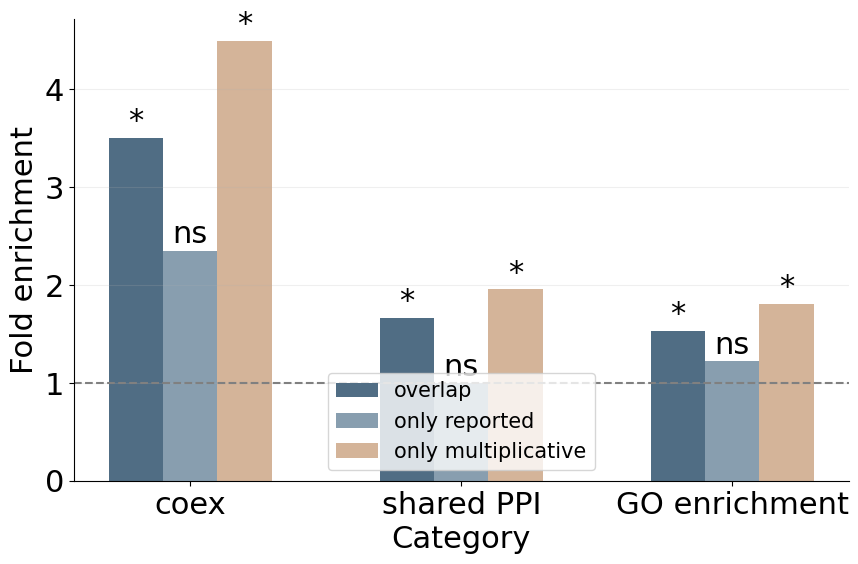

In [24]:
plt.rcParams.update({'font.size': 22})
fig, axs = plt.subplots(figsize=(10,6))
plt.grid(visible=True, axis='y', alpha=0.2)

# data: 
# rows are data category (overlap, only reported, only mult),
# cols are analysis (coex, PPI, GO)
x = np.arange(len(data1[0]))
width = 0.2
plt.bar(x-width, data1[0], width, color=overlap_color) # plots first analysis across all data categories (coex, PPI, GO)
plt.bar(x, data1[1], width, color=only_reported_color)
plt.bar(x+width, data1[2], width, color=only_mult_color)

plt.xticks(x, ['coex', 'shared PPI', 'GO enrichment'])
plt.xlabel("Category")
plt.ylabel("Fold enrichment")
plt.legend(["overlap", "only reported", "only multiplicative"], loc='lower center', prop={'size':15})
#plt.title("Negative interactions")
plt.axhline(1, linestyle="--", color="gray")
sns.despine()

# add annotations for statistical significance
analyses = ["coex", "ppi", "go"]
for column in range(len(data1[0])):
    analysis = analyses[column]
    if dataset == "Kuzmin2020":
        # for 2020 data:
        # overlap and only_mult significant for all analyses, only_reported not significant for all analyses
        # this is the cae when pval threshold is 0.05 or 1
        plt.text(column-width, data1[0][column]+0.02, "*", ha='center', va='bottom')
        plt.text(column, data1[1][column]+0.02, "ns", ha='center', va='bottom')
        plt.text(column+width, data1[2][column]+0.02, "*", ha='center', va='bottom')
    elif dataset == "Kuzmin2018":
        # for 2018 data:
        # overlap significant for all, only_mult significant only for GO and PPI, only_reported only significant for GO
        if analysis == "coex":
            plt.text(column-width, data1[0][column]+0.02, "*", ha='center', va='bottom') # overlap
            plt.text(column, data1[1][column]+0.02, "ns", ha='center', va='bottom') # only_reported
            plt.text(column+width, data1[2][column]+0.02, "ns", ha='center', va='bottom') # only_mult  
        if analysis == "ppi":
            plt.text(column-width, data1[0][column]+0.02, "*", ha='center', va='bottom') # overlap
            plt.text(column, data1[1][column]+0.02, "ns", ha='center', va='bottom') # only_reported
            plt.text(column+width, data1[2][column]+0.02, "*", ha='center', va='bottom') # only_mult
        if analysis == "go":
            plt.text(column-width, data1[0][column]+0.02, "*", ha='center', va='bottom') # overlap
            if p==1:
                plt.text(column, data1[1][column]+0.02, "ns", ha='center', va='bottom') # only_reported
            else:
                plt.text(column, data1[1][column]+0.02, "*", ha='center', va='bottom') # only_reported
            plt.text(column+width, data1[2][column]+0.02, "*", ha='center', va='bottom') # only_mult
        
plt.show()



In [26]:
funcs =  enrich.alleles_2_go_enrichment
genome_wide = func(df)
overlap, only_reported, only_mult, all_reported, all_mult = enrich.outlier_enrichment(df[df.pval < p], "negative", func, multiplicative, tau_mult_sig_val)

In [27]:
print(all_mult['frac']/genome_wide['frac'])
print(all_reported['frac']/genome_wide['frac'])

1.594731586440597
1.5106882804985513


In [28]:
print(all_mult['frac'])
print(all_reported['frac'])
print(genome_wide['frac'])
print(data2)

0.17224163754368446
0.1631644004944376
0.10800666332076841
[[3.4396214  1.62413442 1.51068828]
 [3.7402696  1.73145397 1.59473159]]


In [29]:
#tmp = df[(df.pval <= 0.05) & (df[multiplicative] <= tau_mult_sig_val['neg'])]
overlap = df[(df.pval <= p) & (df.adjusted_interaction_score_epsilon_or_tau <= -0.08) & (df[multiplicative] <= tau_mult_sig_val['neg'])]
only_mult = df[(df.pval <= p) & (df.adjusted_interaction_score_epsilon_or_tau > -0.08) & (df[multiplicative] <= tau_mult_sig_val['neg'])]
only_reported = df[(df.pval <= p) & (df.adjusted_interaction_score_epsilon_or_tau <= -0.08) & (df[multiplicative] > tau_mult_sig_val['neg'])]

print(len(overlap))
print(len(only_mult))
print(len(only_reported))


1527
476
91


/Users/bjarnold/miniconda/envs/epistasis_reanalysis/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/bjarnold/miniconda/envs/epistasis_reanalysis/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":
/Users/bjarnold/miniconda/envs/epistasis_reanalysis/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

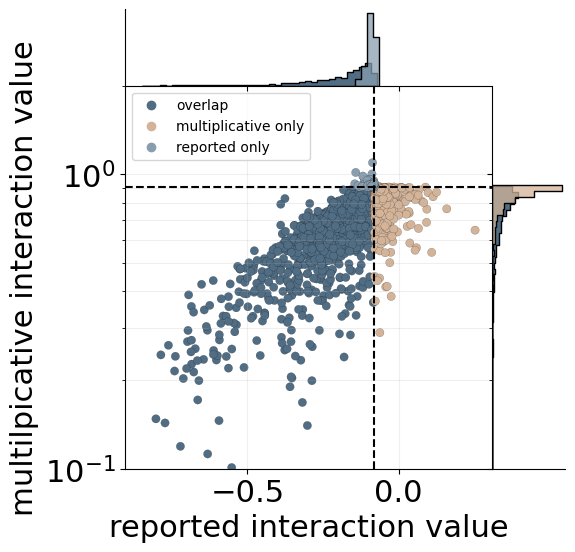

In [35]:
plt.rcParams.update({'font.size': 22})


overlap2 = overlap
only_mult2 = only_mult
only_reported2 = only_reported

overlap2['type'] = "overlap"
only_mult2['type'] = "multiplicative only"
only_reported2['type'] = "reported only"

test = pd.concat([overlap2, only_mult2, only_reported2])
sns.set_palette([overlap_color, only_mult_color, only_reported_color])

g = sns.JointGrid(x='adjusted_interaction_score_epsilon_or_tau', y=multiplicative, data=test, hue='type', space=0)
g.ax_joint.grid(visible=True, axis='both', alpha=0.2, which='both' )

sns.scatterplot(data=test,
                x='adjusted_interaction_score_epsilon_or_tau',
                y=multiplicative,
                hue='type',
                alpha=alph,
                linewidth=lw,
                edgecolor="black",
                ax=g.ax_joint)

if dataset == "Kuzmin2018":
    g.ax_joint.set_ylim(0.1,2)
else:
    g.ax_joint.set_ylim(0.1,2)

g.ax_joint.set_yscale('log')
g.ax_joint.axvline(-0.08, linestyle="--", color="black")
g.ax_joint.axhline(tau_mult_sig_val['neg'], linestyle="--", color="black")

g.ax_joint.set_xlabel("reported interaction value")
g.ax_joint.set_ylabel("multilpicative interaction value")

sns.histplot(overlap, x='adjusted_interaction_score_epsilon_or_tau', color=overlap_color, stat='probability', binwidth=bin_wid, element='step', edgecolor="black", alpha=1, ax=g.ax_marg_x)
sns.histplot(only_reported, x='adjusted_interaction_score_epsilon_or_tau', color=only_reported_color, stat='probability', binwidth=bin_wid, element='step', edgecolor="black",ax=g.ax_marg_x)

sns.histplot(overlap, y=multiplicative, color=overlap_color, stat='probability', binwidth=bin_wid, element='step', edgecolor="black", alpha=1, ax=g.ax_marg_y)
sns.histplot(only_mult, y=multiplicative, color=only_mult_color, stat='probability', binwidth=bin_wid, element='step', edgecolor="black", ax=g.ax_marg_y)

legend_properties = {'size':10}
legendMain=g.ax_joint.legend(prop=legend_properties,loc='upper left')

sns.despine()

In [36]:
x = only_mult[['alleles', multiplicative]]
y = only_reported[['alleles', multiplicative]]
z = overlap[['alleles', multiplicative]]

In [37]:
def genes_2_dict_of_tuples(df):
    genes = {}
    cnt=0
    for i,r in df.iterrows():
        a = r['alleles'].split(',')
        a = tuple([i.split('-')[0].upper() for i in a])
        genes[cnt] = a
        cnt += 1
    return genes

def genes_2_dict_of_tuples_subset(df, subset):
    genes = {}
    cnt=0
    for i,r in df.iterrows():
        a = r['alleles'].split(',')
        a = tuple([i.split('-')[0].upper() for i in a])
        if np.any([i in subset for i in a]):
            genes[cnt] = a
            cnt += 1
    return genes

def genes_2_edge_list(df):
    edges = [] # list of tuples
    for i,r in df.iterrows():
        a = r['alleles'].split(',')
        a = tuple([i.split('-')[0].upper() for i in a])
        edges.extend([(a[0],a[1]), (a[0],a[2]), (a[1],a[2])])
    return edges

In [38]:

H_overlap = hnx.Hypergraph(genes_2_dict_of_tuples(overlap))
H_mult = hnx.Hypergraph(genes_2_dict_of_tuples(pd.concat([overlap, only_mult])))


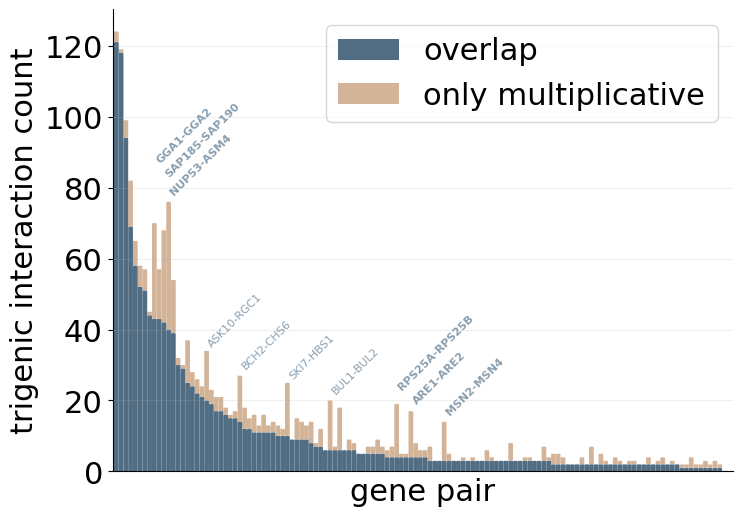

In [39]:
#what pairs do each hyperedge contain?
# RPS25A-RPS25B

def get_gene_pairs(H):
    # for each edge in hypergraph, get the gene pairs it contains
    gene_pairs = defaultdict(int)
    for i,e in enumerate(H.edges):
        # get all pairs within the 3-way edge
        pairs = list(combinations(H.edges[e].elements.keys(), 2))
        for i in pairs:
            gene_pairs[i] += 1
    
    # put these gene pair names, and the number of edges that contain them, in lists to make dataframes later on
    pair, num = [], []
    for k, v in sorted(gene_pairs.items(), key=lambda item: item[1], reverse=True):
        pair.append(k)
        num.append(v)
    return pair, num

gene_pairs_overlap, num_interactions_overlap = get_gene_pairs(H_overlap)
gene_pairs_mult, num_interactions_mult = get_gene_pairs(H_mult)

mult_pairs_df = pd.DataFrame.from_dict({"gene_pairs": gene_pairs_mult, "mult": num_interactions_mult})
overlap_pairs_df  = pd.DataFrame.from_dict({"gene_pairs": gene_pairs_overlap, "overlap": num_interactions_overlap})

pairs_df = overlap_pairs_df.merge(mult_pairs_df, how="outer")

pairs_df.loc[:, 'only multiplicative'] = pairs_df.mult - pairs_df.overlap
pairs_df.loc[:, 'only_mult_fraction'] = pairs_df['only multiplicative']/pairs_df.mult
pairs_df = pairs_df[pairs_df.mult > 1]
pairs_df = pairs_df.sort_values(by='overlap', ascending=False)


pl = pairs_df[['overlap', 'only multiplicative']].plot.bar(stacked=True, color=["#506D84", "#D4B499"], width=1)
pl.figure.set_size_inches(4,4)
pl.set_xlabel('gene pair')
pl.set_ylabel('trigenic interaction count')

pl.figure.set_size_inches(8,6)
plt.rcParams.update({'font.size': 20})

# following code from: https://stackoverflow.com/questions/58425392/bar-chart-with-rounded-corners-in-matplotlib
new_patches = []
for patch in reversed(pl.patches):
    bb = patch.get_bbox()
    color=patch.get_facecolor()
    p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                        abs(bb.width), abs(bb.height),
                        boxstyle="round,pad=-0.0040,rounding_size=0.1",
                        ec="none", fc=color,
                        mutation_aspect=4
                        )
    patch.remove()
    new_patches.append(p_bbox)
for patch in new_patches:
    pl.add_patch(patch)

plt.rcParams.update({'font.size': 8})
if dataset == "Kuzmin2020":
    #f"$\bf{label}$",
    pl.annotate("GGA1-GGA2", (8, 87), color=only_reported_color, rotation=45, fontweight='bold')    
    pl.annotate("SAP185-SAP190", (10, 83), color=only_reported_color, rotation=45, fontweight='bold')
    pl.annotate("NUP53-ASM4", (11, 78), color=only_reported_color, rotation=45, fontweight='bold')
    pl.annotate("ASK10-RGC1", (19, 35), color=only_reported_color, rotation=45)
    pl.annotate("BCH2-CHS6", (26, 29), color=only_reported_color, rotation=45)
    pl.annotate("SKI7-HBS1", (36, 26), color=only_reported_color, rotation=45)
    pl.annotate("BUL1-BUL2", (45, 22), color=only_reported_color, rotation=45)
    pl.annotate("RPS25A-RPS25B", (59, 23), color=only_reported_color, rotation=45, fontweight='bold')
    pl.annotate("ARE1-ARE2", (62, 19), color=only_reported_color, rotation=45, fontweight='bold')
    pl.annotate("MSN2-MSN4", (69, 16), color=only_reported_color, rotation=45, fontweight='bold')
plt.rcParams.update({'font.size': 20})

pl.grid(visible=True, axis='y', alpha=0.2)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    bottom=False,      # ticks along the bottom edge are off
    labelbottom=False)
sns.despine()

In [40]:
def get_third_trigenic_gene(H, gene1, gene2):
    # for each edge in hypergraph, get the gene pairs it contains
    trigenic_genes = []
    for i,e in enumerate(H.edges):
        # get all pairs within the 3-way edge
        genes = list(H.edges[e].elements.keys())
        if gene1 in genes and gene2 in genes:
            gene3 = [i for i in genes if i not in [gene1, gene2]]
            trigenic_genes.extend(gene3)
    return trigenic_genes

#gene_pair = ["NUP53", "ASM4"]
#gene_pair = ["GGA1", "GGA2"]
#gene_pair = ["SAP185", "SAP190"]

gene_pair = ["BUL1", "BUL2"]
#gene_pair = ["SKI7", "HBS1"]
#gene_pair = ["BCH2", "CHS6"]
#gene_pair = ["ASK10", "RGC1"]

#gene_pair = ["MSN2", "MSN4"]
#gene_pair = ["ARE1", "ARE2"]
#gene_pair = ["RPS25A", "RPS25B"]

trigenic_third_gene_overlap = get_third_trigenic_gene(H_overlap, *gene_pair)
trigenic_third_gene_mult = get_third_trigenic_gene(H_mult, *gene_pair)
trigenic_third_gene_mult_unique = [i for i in trigenic_third_gene_mult if i not in trigenic_third_gene_overlap]


In [41]:
print(len(trigenic_third_gene_overlap))
print(len(trigenic_third_gene_mult))
print(len(trigenic_third_gene_mult_unique))

6
20
14


In [42]:
# GO ENRICHMENT FOR SPECIFIC GENE SET

genome_wide = enrich.alleles_2_go_enrichment(df)
overlap, only_reported, only_mult, all_reported, all_mult = enrich.outlier_enrichment(df[df.pval < p], "negative", enrich.alleles_2_go_enrichment, multiplicative, tau_mult_sig_val)

go_counts = defaultdict(int)
cnt = 0
total = 0
gene_pair_gos = [ i for i in db.gene_2_go[gene_pair[0]] if i in db.gene_2_go[gene_pair[1]] ]
print(gene_pair_gos)
for gene in trigenic_third_gene_mult_unique:
#for gene in trigenic_third_gene_overlap:
    total += 1
    if np.any([i in gene_pair_gos for i in db.gene_2_go[gene]]):
        cnt += 1
        
print((cnt/total)/genome_wide['frac'])
print(genome_wide['frac'])

['0070647']
0.0
0.10800666332076841


In [43]:
# SHARED PHYSICAL INTERACTIONS
genome_wide = enrich.fraction_three_shared(df)
overlap, only_reported, only_mult, all_reported, all_mult = enrich.outlier_enrichment(df[df.pval < p], "negative", enrich.fraction_three_shared, multiplicative, tau_mult_sig_val)

s = 0
tot = 0
for i,r in df[df.pval < p].iterrows():
    alleles = sorted(r['alleles'].split(","))
    alleles = [db.gene_stem_name(i.upper()) for i in alleles]
    if gene_pair[0] in alleles and gene_pair[1] in alleles:
        if np.any([i in alleles for i in trigenic_third_gene_mult_unique]):
            s += r.three_shared_physical_interactions
            tot += 1
print(s)
print(tot)
print(s/tot)
print(genome_wide['frac'])
print((s/tot)/genome_wide['frac'])

7
14
0.5
0.1213920360502739
4.118886347642505


In [44]:


for a in alleles:
    if a in db.gene_2_go:
        # many genes are involved in many GO categories; iterate through these
        for g in db.gene_2_go[a]:
            go_counts[g] += 1

counts = np.array([i[1] for i in go_counts.items()])
#print(np.max(counts))
if len(counts) > 0:
    assert np.max(counts) <= 3
#if np.sum(np.any(counts > 1)):
#    go_hit_2plus += 1
#if np.sum(np.any(counts == 3)):
if np.sum(counts == 3) >= 1:
    go_hit_3x += 1


In [ ]:
#tmp = degrees[degrees.all_mult_degree >= 5].sort_values(by='only multiplicative fraction', ascending=False)
tmp = degrees[degrees.all_mult_degree >= 5].sort_values(by='overlap', ascending=False)

    DM strainID  SM1 strainID SM2 strainID     ORF1     ORF2   Gene1   Gene2  \
91        tm1569       tm1876       tm1827  YGR027C  YLR333C  RPS25A  RPS25B   
101       tm1600       tm1889        tm375  YCR048W  YNR019W    ARE1    ARE2   
120       tm1606       tm1895       tm1840  YMR037C  YKL062W    MSN2    MSN4   

     Asym  seq_div_rate  Global profile sim  
91    1.0      0.041332               0.053  
101   1.0      0.051443               0.058  
120   0.0      0.411280               0.038  


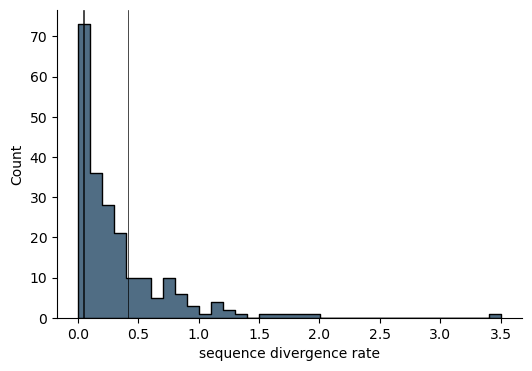

In [ ]:
plt.subplots(figsize=(6,4))


genes_of_interest = ["RPS25A", "MSN2", "ARE1"]
pl = sns.histplot(kuzmin_2020_s10.seq_div_rate, 
                binwidth=0.1, 
                color="#506D84",
                element='step', 
                edgecolor="black", 
                alpha=1)
[plt.axvline(i, color="black", linewidth=0.5) for i in kuzmin_2020_s10.loc[kuzmin_2020_s10.Gene1.isin(genes_of_interest)].seq_div_rate]
pl.set(xlabel='sequence divergence rate')
sns.despine()
print(kuzmin_2020_s10.loc[kuzmin_2020_s10.Gene1.isin(genes_of_interest)])

   DM strainID  SM1 strainID SM2 strainID     ORF1     ORF2   Gene1   Gene2  \
21       tm1647       tm2193       tm1230  YHR108W  YDR358W    GGA2    GGA1   
30        tm160        tm462       tm1202  YKR028W  YJL098W  SAP190  SAP185   
44       tm1533        tm721        tm373  YMR153W  YDL088C   NUP53    ASM4   

    Asym  seq_div_rate  Global profile sim  
21   0.0       0.21630               0.004  
30   0.0       0.21173               0.039  
44   0.0       0.54176               0.260  


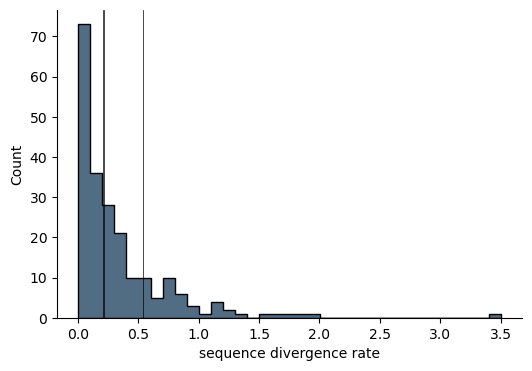

In [ ]:
plt.subplots(figsize=(6,4))


genes_of_interest = ["NUP53", "SAP190", "GGA2"]
pl = sns.histplot(kuzmin_2020_s10.seq_div_rate, 
                binwidth=0.1, 
                color="#506D84",
                element='step', 
                edgecolor="black", 
                alpha=1)
[plt.axvline(i, color="black", linewidth=0.5) for i in kuzmin_2020_s10.loc[kuzmin_2020_s10.Gene1.isin(genes_of_interest)].seq_div_rate]
pl.set(xlabel='sequence divergence rate')
sns.despine()
print(kuzmin_2020_s10.loc[kuzmin_2020_s10.Gene1.isin(genes_of_interest)])